In [4]:
!pip install -q tensorflowjs
!pip install jax-unirep
!pip install tensorflow_decision_forests 
!nvidia-smi

     |████████████████████████████████| 13.4 MB 4.2 MB/s 
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [5]:
#@title Runtime
use_tpu = False #@param

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import tensorflow as tf
import urllib
from dataclasses import dataclass
import tensorflowjs as tfjs
import tensorflow_decision_forests as tfdf
import json
np.random.seed(0)

In [7]:
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/hemo-positive.npz",
    "positive.npz",
)
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/hemo-negative.npz",
    "negative.npz",
)
with np.load("positive.npz") as r:
    pos_data = r[list(r.keys())[0]]
with np.load("negative.npz") as r:
    neg_data = r[list(r.keys())[0]]

# create labels and stich it all into one
# tensor
labels = np.concatenate(
    (
        np.ones((pos_data.shape[0], 1), dtype=pos_data.dtype),
        np.zeros((neg_data.shape[0], 1), dtype=pos_data.dtype),
    ),
    axis=0,
)

features = np.concatenate((pos_data, neg_data), axis=0)

In [8]:
print('Positive data', pos_data.shape[0])
print('Negative data', neg_data.shape[0])

Positive data 1826
Negative data 7490


In [9]:
def decoder(seq_vector):
  alphabet = ['A','R','N','D','C','Q','E','G','H','I', 'L','K','M','F','P','S','T','W','Y','V']
  seq = []
  for i, index in enumerate(seq_vector):
    if index == 0:
      break
    seq.append(alphabet[index-1])
  seq = ''.join(seq)
  return seq

decoded_features = []
for f in features:
  decoded_features.append(decoder(f))

In [10]:
# Generating UniRep representations
from jax_unirep import get_reps
h_avg, h_final, c_final = get_reps(decoded_features)
unirep_features = h_avg

/usr/local/lib/python3.7/dist-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)


In [19]:
@dataclass
class Config:
    batch_size: int
    buffer_size: int
        
config = Config(
                batch_size=32, 
                buffer_size=10000,
               )

In [38]:
# we now need to shuffle before creating TF dataset
# so that our train/test/val splits are random
i = np.arange(len(labels))
np.random.shuffle(i)
labels = labels[i]
unirep_features = unirep_features[i]
data = tf.data.Dataset.from_tensor_slices((unirep_features, labels))
# now split into val, test, train and batch
N = len(data)  
split = int(0.1 * N)
test_data = data.take(split).batch(config.batch_size)
nontest = data.skip(split)
val_data, train_data = nontest.take(split).batch(config.batch_size), \
    nontest.skip(split).shuffle(config.buffer_size).batch(config.batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [68]:
tf.keras.backend.clear_session()
model = tfdf.keras.RandomForestModel()
model.compile(
    metrics=[tf.keras.metrics.AUC(from_logits=False), tf.keras.metrics.BinaryAccuracy(threshold=0.5)])
model.fit(train_data)

Use /tmp/tmppw7u0oa_ as temporary training directory
Starting reading the dataset
233/233 [==============================] - ETA: 0s
Dataset read in 0:00:21.157116
Training model
Model trained in 0:01:28.520847
Compiling model
233/233 [==============================] - 110s 396ms/step


In [73]:
# Visualizing the first three level trees
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0, max_depth=3)

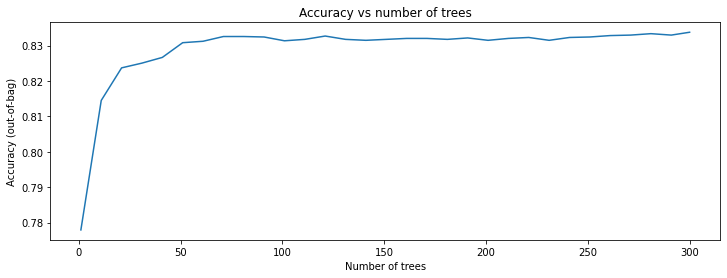

In [78]:
# plot the accuracy during training 
logs = model.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")
plt.title("Accuracy vs number of trees")

plt.show()

In [72]:
test_result = model.evaluate(test_data)
print(f'Test accuracy {test_result[2]:.2f}. Test AUC {test_result[1]:.2f}')

30/30 [==============================] - 6s 13ms/step - loss: 0.0000e+00 - auc: 0.7779 - binary_accuracy: 0.8389
Test accuracy 0.84. Test AUC 0.78
